<h1> Board Games

<b> Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import datetime



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import GridSearchCV

In [3]:
import tensorflow as tf
from tensorflow import keras
#from scikeras.wrappers import KerasRegressor

In [4]:
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
    #print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind

def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    #print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

#ESD test
def ESD_Test(input_series, alpha, max_outliers):
    input_series = np.array(input_series) #Transformation de la colonne en array
    
    #Initialisation des valeurs
    nb_outliers=0
    valeur_atypique_seuil="-"

    
    #Itération pour chaque valeur de la série
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        
        #Récupère les valeurs de la dernière itération où la valeur est considéré comme atypique
        if round(Gstat,4)>round(Gcritical,4) :
            nb_outliers+=1
            valeur_atypique_seuil=input_series[max_index]
            last_Gstat=Gstat
            last_Gcritical=Gcritical
        
        #Supprime la valeur de l'itération pour tester sur d'autres
        input_series = np.delete(input_series, max_index)
   
    #Print des résultats du test
    print("Nombre de valeurs atypiques : "+ str(nb_outliers))
    print("Valeur atypique seuil : {}".format(valeur_atypique_seuil))
    
    if nb_outliers>0 :
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(valeur_atypique_seuil, last_Gstat, last_Gcritical))
    
    if (max_outliers*0.8)<nb_outliers : #Marge de sécurité
        print('\033[1m' + "Veuillez augmenter le nombre d'outlier max par sécurité"+'\033[0m')
    
    return valeur_atypique_seuil

<b> Importation des données

Les données sont issues du kaggle : 
https://www.kaggle.com/datasets/andrewmvd/board-games

In [5]:
#Chemin des données
path="C:/Users/jacinthe/Documents/Scolarite/M2 ECAP/SVM_RNN/Board_games/"

In [6]:
# Importation de la base de données
Games = pd.read_csv(path + "bgg_dataset.csv", sep=";",decimal=',')

In [7]:
Games.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


In [8]:
Games.shape

(20343, 14)

La base de données comprend 16 598 lignes et 11 colonnes.

In [9]:
col_names=["ID","Name","Yr_Published","Min_players","Max_players","Play_Time","Min_age","Users_rated","Rating_avg","BGG_rank","Complexity_avg","Owned_users","Mechanics","Domains"]

In [10]:
Games.columns=col_names

In [11]:
Games.describe()

,ID,Yr_Published,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users
count,20327.000000,20342.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20320.000000
mean,108216.245142,1984.249877,2.019712,5.672221,91.294548,9.601485,840.971391,6.403227,10172.890429,1.991188,1408.457628
std,98682.097298,214.003181,0.690366,15.231376,545.447203,3.645458,3511.562220,0.935911,5872.831597,0.848903,5040.179315
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,1.000000,0.000000,0.000000
25%,11029.000000,2001.000000,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,5087.500000,1.330000,146.000000
50%,88931.000000,2011.000000,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,10173.000000,1.970000,309.000000
75%,192939.500000,2016.000000,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,15258.500000,2.540000,864.000000
max,331787.000000,2022.000000,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,20344.000000,5.000000,155312.000000


<b>Analyse des valeurs manquantes

In [12]:
na = Games.isna().sum()
na.sort_values()

Name                  0
Min_players           0
Max_players           0
Play_Time             0
Min_age               0
Users_rated           0
Rating_avg            0
BGG_rank              0
Complexity_avg        0
Yr_Published          1
ID                   16
Owned_users          23
Mechanics          1598
Domains           10159
dtype: int64

On ne conserve pas la variables ID

In [13]:
Games.drop("ID",axis=1,  inplace = True)
#Games.drop("BGG_rank",axis=1,  inplace = True)

Il manque une valeur pour la variable d'année de publication, on va donc regarder à quel jeu correspond cette valeur.

In [14]:
Games[Games.Yr_Published.isna()==True]

,Name,Yr_Published,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,Domains
13984,Hus,NaN,2,2,40,0,38,6.28,13986,2.0,NaN,NaN,NaN


Pour ce jeu, il manque d'autres informations dont le nombre d'utilisateurs qui ont le jeu, la méchanique et le domaine. Il ne semble donc pas pertinent de le concerver. On va donc le supprimer.

In [15]:
Games=Games[(Games.Name!="Hus")==True]

In [16]:
na = Games.isna().sum()
na.sort_values()

Name                  0
Yr_Published          0
Min_players           0
Max_players           0
Play_Time             0
Min_age               0
Users_rated           0
Rating_avg            0
BGG_rank              0
Complexity_avg        0
Owned_users          22
Mechanics          1597
Domains           10158
dtype: int64

In [17]:
Games[Games.Owned_users.isna()==True]

,Name,Yr_Published,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,Domains
2828,Guildhall Fantasy: Fellowship,2016.0,2,4,45,10,565,7.13,2830,2.00,NaN,"Hand Management, Take That, Set Collection",NaN
3590,Guildhall Fantasy: Alliance,2016.0,2,4,45,10,360,7.20,3592,2.14,NaN,"Hand Management, Set Collection, Take That",NaN
3739,Guildhall Fantasy: Coalition,2016.0,2,4,45,10,336,7.19,3741,2.13,NaN,"Hand Management, Set Collection, Take That",NaN
5807,Chariot Lords,1999.0,3,4,360,12,221,6.68,5809,3.00,NaN,"Area Movement, Variable Player Powers",NaN
9202,Operation Market Garden: Descent into Hell,1985.0,2,2,120,12,94,6.72,9204,3.00,NaN,"Dice Rolling, Events, Grid Movement, Hexagon G...",NaN
9317,Hoax,1981.0,3,12,45,10,216,5.97,9319,1.38,NaN,"Deduction, Hidden Roles, Voting",NaN
10075,Devil Boats: PT Boats in the Solomons,2021.0,1,1,60,14,49,7.84,10077,2.83,NaN,NaN,NaN
10776,Ace of Aces: Jet Eagles,1990.0,2,2,20,10,110,6.26,10778,2.00,NaN,NaN,NaN
10835,Die Erben von Hoax,1999.0,3,8,45,12,137,6.05,10837,2.00,NaN,NaN,NaN
11152,Rommel in North Africa: The War in the Desert ...,1986.0,2,2,0,12,53,6.76,11154,4.00,NaN,NaN,NaN


On constate que pour les observations pour lesquelles il manque le nombre d'utilisateurs en possession du jeu il manque également le domaine et pour la plupart la méchanique de jeu. On supprime donc ces valeurs manquantes.

In [18]:
Games=Games[Games.Owned_users.isna()==False]

In [19]:
Games.shape

(20320, 13)

In [20]:
na = Games.isna().sum()
na.sort_values()

Name                  0
Yr_Published          0
Min_players           0
Max_players           0
Play_Time             0
Min_age               0
Users_rated           0
Rating_avg            0
BGG_rank              0
Complexity_avg        0
Owned_users           0
Mechanics          1581
Domains           10136
dtype: int64

On décide de supprimer les variables pour lesquelles le domaine est manquant car c'est la variable sur laquelle on souhaite réaliser une classification

In [21]:
Games=Games[Games.Domains.isna()==False]

In [22]:
na = Games.isna().sum()
na.sort_values()

Name                0
Yr_Published        0
Min_players         0
Max_players         0
Play_Time           0
Min_age             0
Users_rated         0
Rating_avg          0
BGG_rank            0
Complexity_avg      0
Owned_users         0
Domains             0
Mechanics         475
dtype: int64

In [23]:
Games=Games[Games.Mechanics.isna()==False]

In [24]:
na = Games.isna().sum()
na.sort_values()

Name              0
Yr_Published      0
Min_players       0
Max_players       0
Play_Time         0
Min_age           0
Users_rated       0
Rating_avg        0
BGG_rank          0
Complexity_avg    0
Owned_users       0
Mechanics         0
Domains           0
dtype: int64

In [25]:
Games.shape

(9709, 13)

In [26]:
Games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9709 entries, 0 to 20342
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            9709 non-null   object 
 1   Yr_Published    9709 non-null   float64
 2   Min_players     9709 non-null   int64  
 3   Max_players     9709 non-null   int64  
 4   Play_Time       9709 non-null   int64  
 5   Min_age         9709 non-null   int64  
 6   Users_rated     9709 non-null   int64  
 7   Rating_avg      9709 non-null   float64
 8   BGG_rank        9709 non-null   int64  
 9   Complexity_avg  9709 non-null   float64
 10  Owned_users     9709 non-null   float64
 11  Mechanics       9709 non-null   object 
 12  Domains         9709 non-null   object 
dtypes: float64(4), int64(6), object(3)
memory usage: 1.0+ MB


On recode certaines variables qui ne sont pas du bon type.  <p>
-> On Owned users en integer

In [27]:
#Transformer year published en int
Games['Yr_Published'] = Games.Yr_Published.astype('int64')
Games['Owned_users'] = Games.Owned_users.astype('int64')

<b> Analyse des valeurs atypiques

In [28]:
num_col=Games.select_dtypes(include=['int64','float64']).columns.tolist()
print(num_col)

['Yr_Published', 'Min_players', 'Max_players', 'Play_Time', 'Min_age', 'Users_rated', 'Rating_avg', 'BGG_rank', 'Complexity_avg', 'Owned_users']


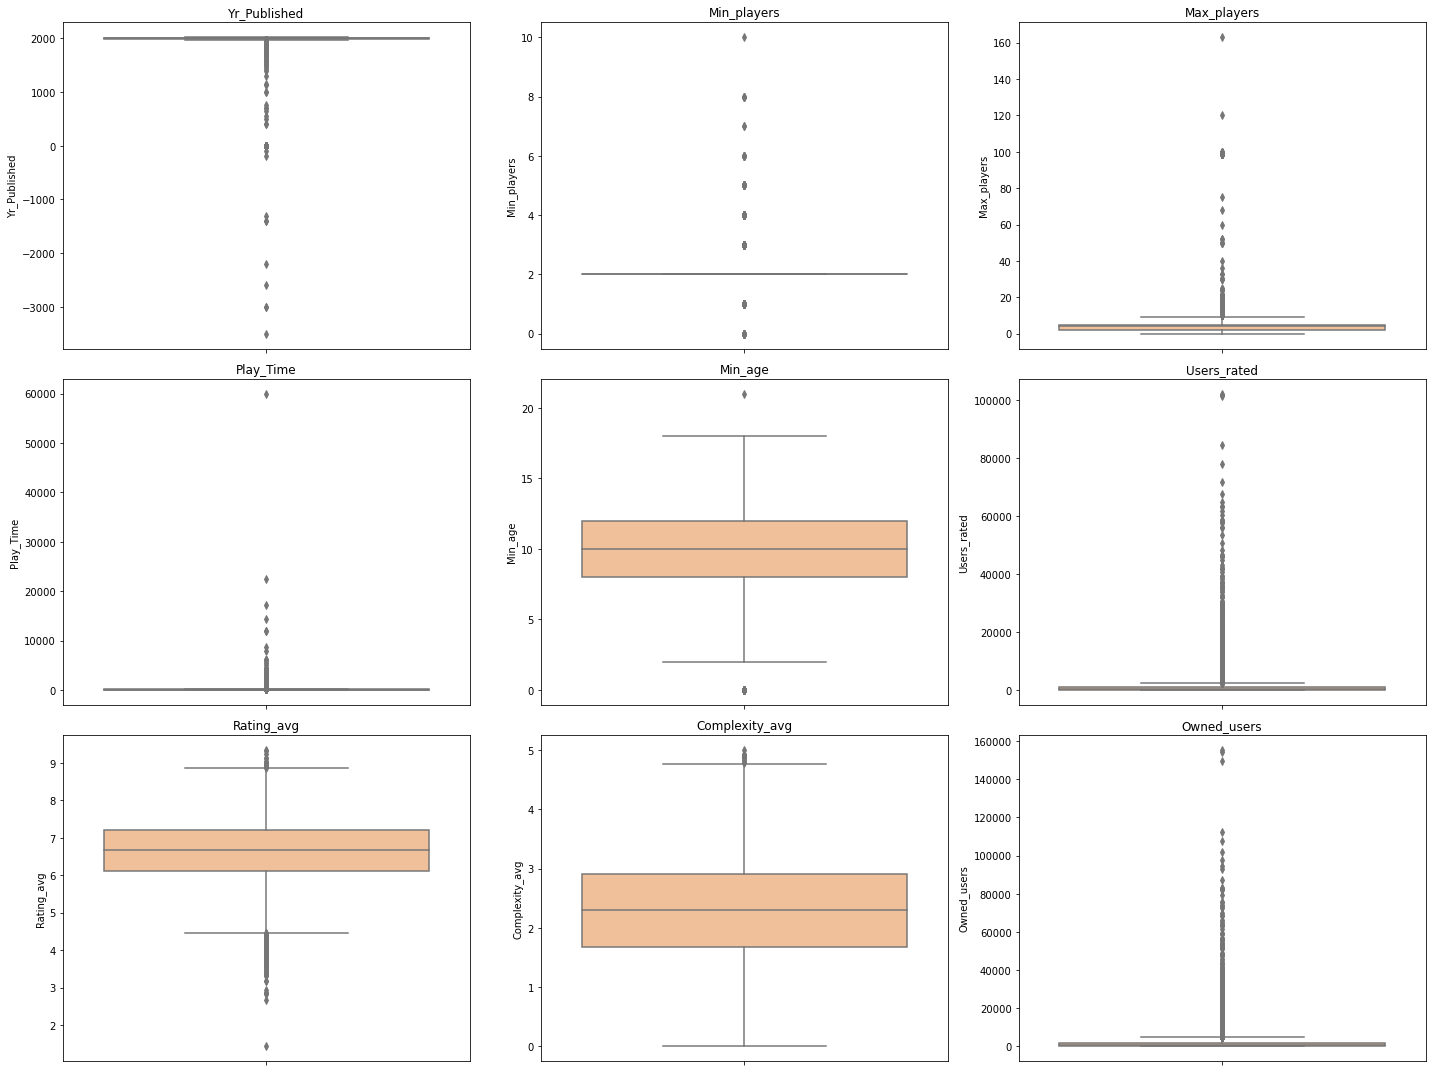

In [29]:
#Boxplot pour analyser les atypiques

fig=plt.figure(figsize=(20,15),facecolor='white')

gs=fig.add_gridspec(3,3)

ax=[_ for _ in range(9)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[0,2])

ax[3]=fig.add_subplot(gs[1,0])
ax[4]=fig.add_subplot(gs[1,1])
ax[5]=fig.add_subplot(gs[1,2])

ax[6]=fig.add_subplot(gs[2,0])
ax[7]=fig.add_subplot(gs[2,1])
ax[8]=fig.add_subplot(gs[2,2])

sns.boxplot(y=Games['Yr_Published'],data=Games,orient="v",ax=ax[0],color="#FEBE8C").set_title('Yr_Published')
sns.boxplot(y=Games['Min_players'],data=Games,orient="v",ax=ax[1],color="#FEBE8C").set_title('Min_players')
sns.boxplot(y=Games['Max_players'],data=Games,orient="v",ax=ax[2],color="#FEBE8C").set_title('Max_players')
sns.boxplot(y=Games['Play_Time'],data=Games,orient="v",ax=ax[3],color="#FEBE8C").set_title('Play_Time')
sns.boxplot(y=Games['Min_age'],data=Games,orient="v",ax=ax[4],color="#FEBE8C").set_title('Min_age')
sns.boxplot(y=Games['Users_rated'],data=Games,orient="v",ax=ax[5],color="#FEBE8C").set_title('Users_rated')
sns.boxplot(y=Games['Rating_avg'],data=Games,orient="v",ax=ax[6],color="#FEBE8C").set_title('Rating_avg')
sns.boxplot(y=Games['Complexity_avg'],data=Games,orient="v",ax=ax[7],color="#FEBE8C").set_title('Complexity_avg')
sns.boxplot(y=Games['Owned_users'],data=Games,orient="v",ax=ax[8],color="#FEBE8C").set_title('Owned_users')

plt.tight_layout()
plt.show()

In [30]:
Games.Yr_Published.describe()

count    9709.000000
mean     1987.028736
std       194.479788
min     -3500.000000
25%      1996.000000
50%      2007.000000
75%      2014.000000
max      2021.000000
Name: Yr_Published, dtype: float64

In [31]:
Games[Games.Yr_Published<0]

,Name,Yr_Published,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,Domains
172,Go,-2200,2,2,180,8,14843,7.64,173,4.00,20398,"Enclosure, Square Grid",Abstract Games
1275,Backgammon,-3000,2,2,30,8,11680,6.54,1276,2.02,17747,"Advantage Token, Betting and Bluffing, Dice Ro...",Abstract Games
8174,Senet,-3500,2,2,30,6,664,5.82,8176,1.48,1343,"Dice Rolling, Roll / Spin and Move",Abstract Games
8924,The Royal Game of Ur,-2600,2,2,30,10,549,5.90,8926,1.31,1162,"Dice Rolling, Roll / Spin and Move, Square Gri...",Abstract Games
15134,Petteia,-100,2,2,20,5,51,6.01,15136,2.17,93,"Action Queue, Area Majority / Influence",Abstract Games
19648,Three Men's Morris,-1400,2,2,5,5,60,4.31,19650,1.25,60,"Pattern Building, Point to Point Movement",Abstract Games
20002,Nine Men's Morris,-1400,2,2,20,6,1310,5.36,20004,1.84,1642,"Pattern Building, Point to Point Movement",Abstract Games
20219,Marbles,-3000,1,0,10,4,473,4.69,20221,1.10,399,Flicking,Children's Games
20341,Chutes and Ladders,-200,2,6,30,3,3783,2.86,20343,1.02,4400,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games
20342,Tic-Tac-Toe,-1300,2,2,1,4,3275,2.68,20344,1.16,1374,"Paper-and-Pencil, Pattern Building","Abstract Games, Children's Games"


Les dates de publication des jeux de société sont entre -3500 et 2021. <p>
Lorsque l'on observe les jeux pour lesquels la date est négative, on constate qu'il s'agit de jeux traditionnels, par exemple on y retrouve le jeu de go. Il ne s'agit donc pas nécessairement de valeur aberrante. <p>
    
On fait le choix de ne conserver que les jeux contemporains. Pour ce faire, on supprime les jeux créés avant le 19ème siècle (1800).

In [32]:
Games[Games.Yr_Published<=1800].count() #On supprime 96 observations

Name              96
Yr_Published      96
Min_players       96
Max_players       96
Play_Time         96
Min_age           96
Users_rated       96
Rating_avg        96
BGG_rank          96
Complexity_avg    96
Owned_users       96
Mechanics         96
Domains           96
dtype: int64

In [33]:
Games=Games[Games.Yr_Published>=1800]

In [34]:
Games.Yr_Published.describe()

count    9615.000000
mean     2002.904212
std        16.133347
min      1800.000000
25%      1996.000000
50%      2008.000000
75%      2014.000000
max      2021.000000
Name: Yr_Published, dtype: float64

On créer une varaible âge du jeu, plus facilement interprétable que l'année de publication. <p>
Les données ayant été collectées en février 2021, on calcul l'âge du jeu à la date où les données ont été collectées.

In [35]:
Games['Age']=2021-Games.Yr_Published

On supprime la variable date de publication

In [36]:
Games.drop('Yr_Published',axis=1,inplace=True)

In [37]:
num_col.remove('Yr_Published')
num_col.append('Age')


On constate qu'il existe des jeux dans la base de données pour lesquels le nombre de joueurs minimum et le nombre de joueurs maximum sont nuls. On supprime c'est jeux car il s'agit de valeurs aberrantes.

In [38]:
#Suppression des observations avec le nombre de joueurs maximum nul et celles avec le nombre de joueurs minimum nul
Games=Games[Games.Max_players!=0]
Games=Games[Games.Min_players!=0]

In [39]:
Games.shape

(9562, 13)

Il y a une observation pour lequel le nombre de joueurs minimum est de 10. Il s'agit d'un jeu (haggle) qui demande effectivement d'être nombreux pour pouvoir y jouer (cf bgg). Même si cette valeur peut être considérée comme atypique, on fait le choix de la garder car cela peut avoir un impact important sur la note du jeu.

In [40]:
Games[Games.Max_players>99]

,Name,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,Domains,Age
116,Cartographers,1,100,45,10,10754,7.76,117,1.91,19320,"Bingo, Grid Coverage, Line Drawing, Paper-and-...",Family Games,2
125,Welcome To...,1,100,25,10,17370,7.61,126,1.82,27392,"Bingo, Paper-and-Pencil, Pattern Building, Sol...",Family Games,3
4695,Prawo Dżungli,2,100,10,8,468,6.53,4697,1.38,557,Pattern Recognition,Party Games,14
5820,Black Powder: Second Edition,2,120,360,12,136,7.35,5822,2.69,345,Dice Rolling,Wargames,12
11704,Haggle,10,100,300,10,52,6.69,11706,2.10,51,"Hand Management, Set Collection, Trading",Party Games,58
13602,Fairy Meat,2,100,60,12,85,5.93,13604,1.63,203,Dice Rolling,Thematic Games,21
16539,Pit Fighter: Fantasy Arena,2,163,30,8,45,5.57,16541,1.80,204,"Campaign / Battle Card Driven, Hexagon Grid",Wargames,15


On constate qu'il y a deux jeux pour lesquels le maximum de joueurs est de plus de 100. Lorsqu'un jeu n'a pas de maximum de joueurs indiqué, il est souvent considéré que le maximum est de 99 ou 100. On décide donc de corriger ces valeurs en leur attribuant la valeur de 100.

In [41]:
Games['Max_players'] = Games['Max_players'].replace(120, 100)
Games['Max_players'] = Games['Max_players'].replace(163, 100)

In [42]:
Games.Play_Time.describe()

count     9562.000000
mean       138.236771
std        782.475156
min          0.000000
25%         30.000000
50%         60.000000
75%        120.000000
max      60000.000000
Name: Play_Time, dtype: float64

Le temps de jeu minimum est de 0. Ce sont probablement des erreurs de saisies ou des des informations manquantes. Le temps de jeu correspond au temps de jeu indiqué par l'éditeur du jeu. <p>
On supprime les jeux pour lesquels le temps de jeu est nul.

In [43]:
Games[Games.Play_Time==0]

,Name,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,Domains,Age
7381,The Battles of Mollwitz 1741 and Chotusitz 1742,2,2,0,0,55,8.51,7383,4.50,301,"Dice Rolling, Hexagon Grid, Simulation",Wargames,4
7588,Footy Manager,1,8,0,6,82,8.06,7590,2.00,104,"Dice Rolling, Paper-and-Pencil, Simulation",Thematic Games,10
7608,Waterloo Campaign 1815,2,2,0,0,82,7.34,7610,1.86,478,Hexagon Grid,Wargames,2
7913,Hanau 1813,2,2,0,0,55,8.16,7915,3.08,210,"Chit-Pull System, Hexagon Grid",Wargames,8
7965,Premières Gloires,2,2,0,0,51,8.23,7967,3.50,215,"Chit-Pull System, Dice Rolling, Hexagon Grid, ...",Wargames,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19349,U-Build Battleship,2,2,0,7,51,4.41,19351,1.43,182,Secret Unit Deployment,Children's Games,11
19601,Go Fish!,2,4,0,3,53,4.12,19603,1.00,61,Memory,Children's Games,24
19831,XIG: The Four Elements,2,2,0,8,64,3.99,19833,1.40,151,Tile Placement,Customizable Games,16
19972,The Eagle and the Sun,2,2,0,12,65,3.64,19974,4.80,176,"Chit-Pull System, Dice Rolling, Grid Movement,...",Wargames,30


In [44]:
Games=Games[Games.Play_Time!=0]
print(Games.shape)

(9392, 13)


In [45]:
Games.Play_Time.describe()

count     9392.000000
mean       140.738927
std        789.302676
min          1.000000
25%         30.000000
50%         60.000000
75%        120.000000
max      60000.000000
Name: Play_Time, dtype: float64

La variable play time présente beaucoup d'observations qui semblent atypiques. Le temps de jeu maximal est de 60000 minutes. C'est bien supérieur au temps de 75% des jeux qui est de 120 minutes. <p>
La moyenne est plus de 2 fois supérieures à la médiane. <p>
Le temps de jeu correspond au temps de jeu indiqué par l'éditeur ou par les internautes. Lorsqu'il y a un temps de jeu maximum, c'est celui-ci qui est indiqué dans la base de donnée. C'est pourquoi certains jeux ont des temps de jeu particulièrement élevé. On remarque que les jeux avec les temps de jeu les plus élevés sont des jeux de la catégorie wargames. Les jeux de guerres sont généralement des jeux de plateaux qui peuvent être parfois très long. L'ensemble des temps de jeux très long ne sont donc pas des valeurs aberrantes. On peut toutefois soupçonner des valeurs comme 60000 d'être aberrantes. On fait donc le choix de supprimer les jeux qui durent plus de 24h soit 1440 minutes.

In [46]:
Games=Games[Games.Play_Time<1440]
print(Games.shape)

(9318, 13)


In [47]:
Games.Min_age.describe()

count    9318.000000
mean        9.964907
std         3.543676
min         0.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: Min_age, dtype: float64

In [48]:
Games.Domains[Games.Min_age==0].value_counts()

Wargames                                    373
Abstract Games                               66
Strategy Games                               19
Thematic Games                               18
Family Games                                 16
Thematic Games, Wargames                     14
Customizable Games                           13
Children's Games                              9
Party Games                                   6
Strategy Games, Thematic Games                5
Abstract Games, Family Games                  2
Customizable Games, Strategy Games            2
Family Games, Strategy Games                  2
Strategy Games, Wargames                      1
Family Games, Party Games                     1
Abstract Games, Wargames                      1
Strategy Games, Thematic Games, Wargames      1
Name: Domains, dtype: int64

In [49]:
games_domains=["Wargames", "Abstract Games", "Strategy Games", "Thematic Games", "Family Games", "Children's Games", "Party Games","Customizable Games"]

In [50]:
for i in games_domains :
    print(i, ":" , Games.Min_age[Games.Domains==i].median())


Wargames : 12.0
Abstract Games : 8.0
Strategy Games : 12.0
Thematic Games : 12.0
Family Games : 8.0
Children's Games : 5.0
Party Games : 10.0
Customizable Games : 10.0


In [51]:
for i in games_domains :
    Games['Min_age'][Games.Domains==i] = Games['Min_age'][Games.Domains==i].replace(0, Games.Min_age[Games.Domains==i].median())


In [52]:
Games.Min_age.describe()

count    9318.000000
mean       10.588538
std         2.620427
min         0.000000
25%         8.000000
50%        12.000000
75%        12.000000
max        21.000000
Name: Min_age, dtype: float64

Pour les jeux pour lesquels il reste des âge minimum à 0, ils combinent plusieurs types de jeu. On leur attribue donc la médiane de l'ensemble des jeux du dataset.  

In [53]:
Games.Domains[Games.Min_age==0].value_counts()

Thematic Games, Wargames                    14
Strategy Games, Thematic Games               5
Abstract Games, Family Games                 2
Family Games, Strategy Games                 2
Customizable Games, Strategy Games           2
Family Games, Party Games                    1
Strategy Games, Wargames                     1
Abstract Games, Wargames                     1
Strategy Games, Thematic Games, Wargames     1
Name: Domains, dtype: int64

In [54]:
Games['Min_age'] = Games['Min_age'].replace(0, Games.Min_age.median())


In [55]:
Games.Users_rated.describe()

count      9318.000000
mean       1660.810045
std        5048.248657
min          30.000000
25%          94.000000
50%         320.500000
75%        1139.000000
max      102214.000000
Name: Users_rated, dtype: float64

Il y a une grande différence entre la moyenne et la médiane, cependant on décide dans un premier temps de conserver l'ensemble de ces observations. En effet, il y a quelques variables qui ont beaucoup plus de votes que la médiane mais il s'agit de jeu très populaires (Catan par exemple) dont on ne souhaite pas se séparer.

In [56]:
Games.Rating_avg.describe()

count    9318.000000
mean        6.624804
std         0.837130
min         2.830000
25%         6.110000
50%         6.650000
75%         7.200000
max         9.340000
Name: Rating_avg, dtype: float64

Les jeux sont notés de 0 à 10. On remarque la moyenne et la médiane sont relativement proches. On décide de conserver l'ensemble des observations de cette variable. Il nous semble pertinent de chercher à comprendre les valeurs tant faibles qu'élevées de cette variable.

In [57]:
Games.Complexity_avg.describe()

count    9318.000000
mean        2.309123
std         0.830720
min         0.000000
25%         1.650000
50%         2.285000
75%         2.887500
max         5.000000
Name: Complexity_avg, dtype: float64

Les jeux sont notés de 0 à 5.

In [58]:
Games[Games.Complexity_avg==0]

,Name,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,Domains,Age
8399,Fendo,2,2,45,10,65,7.65,8401,0.0,105,"Area Majority / Influence, Enclosure, Point to...",Abstract Games,7
9480,Sleepers,2,2,30,8,42,7.78,9482,0.0,58,"Enclosure, Memory, Network and Route Building,...",Abstract Games,9
10049,Kaleidos Junior,2,99,30,5,70,6.72,10051,0.0,160,"Paper-and-Pencil, Pattern Recognition",Children's Games,24
11697,The Pacific War: From Pearl Harbor to the Phil...,2,2,120,12,34,7.19,11699,0.0,119,"Area Movement, Campaign / Battle Card Driven, ...",Wargames,5
12378,Dragon Chess,2,2,30,10,31,7.18,12380,0.0,70,Grid Movement,Abstract Games,16
13166,Isi,2,2,30,12,38,6.51,13168,0.0,82,"Modular Board, Network and Route Building",Abstract Games,22
15045,The Terminator: CCG,2,2,120,10,45,6.12,15047,0.0,156,"Hand Management, Secret Unit Deployment",Customizable Games,21
15460,Junta,2,2,30,8,36,5.95,15462,0.0,84,"Area Majority / Influence, Grid Movement",Abstract Games,46
16091,Zingo! 1-2-3,2,6,5,4,36,5.91,16093,0.0,97,Pattern Recognition,Children's Games,12
16682,The Touch,2,6,45,5,37,5.58,16684,0.0,55,"Line Drawing, Memory, Pattern Building, Set Co...",Children's Games,19


Il y a 16 jeux pour lesquels le niveau de complexité est de 0. Il s'agit de jeu pour lesquels les utilisateurs de bgg n'ont pas noté la complexité donc on supprime ces jeux.

In [59]:
Games=Games[Games.Complexity_avg!=0]
Games.shape

(9302, 13)

In [60]:
Games.Owned_users.describe()

count      9302.000000
mean       2662.708342
std        7215.026365
min           7.000000
25%         271.000000
50%         716.000000
75%        2145.500000
max      155312.000000
Name: Owned_users, dtype: float64

On fait le choix de conserver l'ensemble de ces variables dans un premier temps.

<b>Corrélations entre les variables quantitatives

In [61]:
corr=Games.corr(method="spearman")
corr.style.background_gradient(cmap="BuPu")

,Min_players,Max_players,Play_Time,Min_age,Users_rated,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Age
Min_players,1.000000,0.279719,-0.133727,-0.121191,0.072973,-0.204812,0.035943,-0.174673,0.019756,0.162850
Max_players,0.279719,1.000000,-0.197834,-0.156223,0.343839,-0.122513,-0.164623,-0.264977,0.267379,-0.106733
Play_Time,-0.133727,-0.197834,1.000000,0.601681,-0.144872,0.386972,-0.072205,0.778384,-0.037416,0.078814
Min_age,-0.121191,-0.156223,0.601681,1.000000,0.029304,0.418510,-0.221800,0.620086,0.114332,-0.154514
Users_rated,0.072973,0.343839,-0.144872,0.029304,1.000000,0.266408,-0.826472,-0.075578,0.962309,-0.312946
Rating_avg,-0.204812,-0.122513,0.386972,0.418510,0.266408,1.000000,-0.678327,0.525726,0.299205,-0.483945
BGG_rank,0.035943,-0.164623,-0.072205,-0.221800,-0.826472,-0.678327,1.000000,-0.206106,-0.810848,0.465179
Complexity_avg,-0.174673,-0.264977,0.778384,0.620086,-0.075578,0.525726,-0.206106,1.000000,0.007285,-0.029045
Owned_users,0.019756,0.267379,-0.037416,0.114332,0.962309,0.299205,-0.810848,0.007285,1.000000,-0.316296
Age,0.162850,-0.106733,0.078814,-0.154514,-0.312946,-0.483945,0.465179,-0.029045,-0.316296,1.000000


<AxesSubplot:title={'center':'Matrice de corrélation'}>

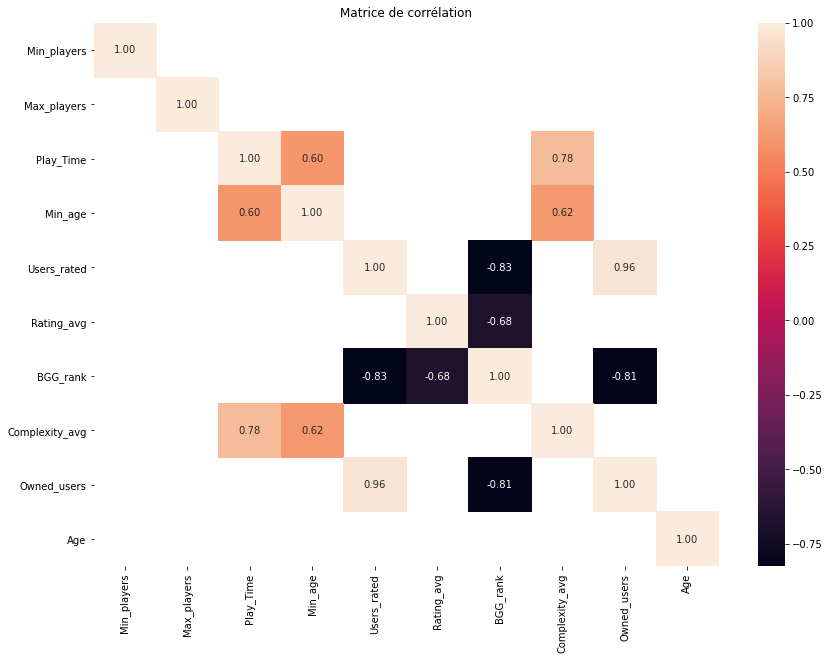

In [62]:
# Correlation Matrix formation
corr_matrix = Games.loc[:,num_col].corr(method='spearman')
 
    # Set the width and height of the figure
plt.figure(figsize=(14,10))

# Add title
plt.title("Matrice de corrélation")

#Using heatmap to visualize the correlation matrix

sns.heatmap(corr_matrix[abs(corr_matrix)>=0.60], annot=True, fmt = '.2f')

On note 3 couples de varaibles fortement corrélées :
-La complexité moyenne et le temps de jeu sont corrélés positivement.
-L'âge minimum et la complexité moyenne sont aussi corréles positivement. 
-Le nombre de joueurs qui déclarent posséder le jeu et le nombre de joueurs qui ont attribué une note au jeu. c'est deux varaibles sont très fortement corrélées (0,96). On fait donc le choix de ne conserver que le nombre de joueurs qui possèdent le jeu. On écarte le nombre de votants car c'est la variable la moins pertinente des deux à conserver puisqu'on peut supposer que le nombre de votants intervient dans le calcul de la variable que nous cherchons à prédire qui est la note moyenne.

In [63]:
Games.drop('Users_rated',axis=1,inplace=True)

In [64]:
Games.describe()

,Min_players,Max_players,Play_Time,Min_age,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Age
count,9302.000000,9302.000000,9302.000000,9302.000000,9302.000000,9302.000000,9302.000000,9302.000000,9302.000000
mean,1.953988,4.715653,104.057192,10.631047,6.626050,7443.350032,2.313095,2662.708342,18.093206
std,0.628012,6.883965,129.273038,2.550885,0.835887,5819.613453,0.825891,7215.026365,16.200245
min,1.000000,1.000000,1.000000,2.000000,2.830000,1.000000,1.000000,7.000000,0.000000
25%,2.000000,2.000000,30.000000,8.000000,6.110000,2442.250000,1.660000,271.000000,7.000000
50%,2.000000,4.000000,60.000000,12.000000,6.650000,5965.500000,2.290000,716.000000,13.000000
75%,2.000000,5.000000,120.000000,12.000000,7.200000,11677.750000,2.890000,2145.500000,25.000000
max,10.000000,100.000000,1260.000000,21.000000,9.340000,20342.000000,5.000000,155312.000000,221.000000


<b> Traitement des variables qualitatives

La variable "Mechanics" indique les différentes mécaniques de jeux qui peuvent être utilisées dans le jeu. <p>
Certains jeux on plus d'une mécanique qui interviennent. On cherche à voir qu'elles sont les différentes mécaniques existantes.

In [65]:
#On fait une liste avec l'ensemble des mécaniques qui apparaissent dans le dataset
mecanics=[]
for i in Games.Mechanics :
    value=i.split(",")
    mecanics= mecanics + value


In [66]:
#On créer une liste qui contient toutes les mécaniques de jeu, on retire les espaces inutiles
values=[]
for i in mecanics:
    m = i.lstrip()
    values.append(m)

In [67]:
values

['Action Queue',
 'Action Retrieval',
 'Campaign / Battle Card Driven',
 'Card Play Conflict Resolution',
 'Communication Limits',
 'Cooperative Game',
 'Deck Construction',
 'Deck Bag and Pool Building',
 'Grid Movement',
 'Hand Management',
 'Hexagon Grid',
 'Legacy Game',
 'Modular Board',
 'Once-Per-Game Abilities',
 'Scenario / Mission / Campaign Game',
 'Simultaneous Action Selection',
 'Solo / Solitaire Game',
 'Storytelling',
 'Variable Player Powers',
 'Action Points',
 'Cooperative Game',
 'Hand Management',
 'Legacy Game',
 'Point to Point Movement',
 'Set Collection',
 'Trading',
 'Variable Player Powers',
 'Hand Management',
 'Income',
 'Loans',
 'Market',
 'Network and Route Building',
 'Score-and-Reset Game',
 'Tech Trees / Tech Tracks',
 'Turn Order: Stat-Based',
 'Variable Set-up',
 'Card Drafting',
 'Drafting',
 'End Game Bonuses',
 'Hand Management',
 'Hexagon Grid',
 'Income',
 'Set Collection',
 'Solo / Solitaire Game',
 'Take That',
 'Tile Placement',
 'Turn Order

In [68]:
unique_mec=np.unique(values).tolist()

In [69]:
unique_mec

['Acting',
 'Action Drafting',
 'Action Points',
 'Action Queue',
 'Action Retrieval',
 'Action Timer',
 'Action/Event',
 'Advantage Token',
 'Alliances',
 'Area Majority / Influence',
 'Area Movement',
 'Area-Impulse',
 'Auction/Bidding',
 'Auction: Dexterity',
 'Auction: Dutch',
 'Auction: Dutch Priority',
 'Auction: English',
 'Auction: Fixed Placement',
 'Auction: Once Around',
 'Auction: Sealed Bid',
 'Auction: Turn Order Until Pass',
 'Automatic Resource Growth',
 'Betting and Bluffing',
 'Bias',
 'Bingo',
 'Bribery',
 'Campaign / Battle Card Driven',
 'Card Drafting',
 'Card Play Conflict Resolution',
 'Catch the Leader',
 'Chaining',
 'Chit-Pull System',
 'Closed Economy Auction',
 'Command Cards',
 'Commodity Speculation',
 'Communication Limits',
 'Connections',
 'Constrained Bidding',
 'Contracts',
 'Cooperative Game',
 'Crayon Rail System',
 'Critical Hits and Failures',
 'Cube Tower',
 'Deck Bag and Pool Building',
 'Deck Construction',
 'Deduction',
 'Delayed Purchase',
 

In [70]:
len(unique_mec)

182

Il y a 182 mécaniques de jeu différentes.

Un jeu peu avoir plusieurs mécaniques. On créer une variables correspondant au nombre de mécaniques par jeux. On peut supposer que c'est une varaible qui pourrait avoir un impact sur la popularité du jeu, soit parce qu'un jeu avec trop de mécanique serait difficile d'accès pour un large public soit parce qu'il permet d'avoir différente dynamique au cours d'une partie qui rendent attrayant ce jeu.

In [71]:
Games['Nb_Mechanics']=0
for i in range(Games.shape[0]) :
    value=Games.Mechanics.iloc[i].split(",")
    Games['Nb_Mechanics'].iloc[i]=len(value)
    

C:\Users\jacinthe\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [72]:
values_df=pd.DataFrame(values,index=values,columns={"Mechanics"})
order=values_df.value_counts()
print(order[:10])

Mechanics                
Dice Rolling                 3433
Hexagon Grid                 1955
Hand Management              1881
Simulation                   1585
Variable Player Powers       1281
Set Collection               1216
Grid Movement                1004
Modular Board                 913
Tile Placement                908
Area Majority / Influence     906
dtype: int64


In [73]:
pourcentage_meca=(order/Games.shape[0])*100

In [74]:
pourcentage_meca[pourcentage_meca>=10]

Mechanics             
Dice Rolling              36.906042
Hexagon Grid              21.016986
Hand Management           20.221458
Simulation                17.039346
Variable Player Powers    13.771232
Set Collection            13.072458
Grid Movement             10.793378
dtype: float64

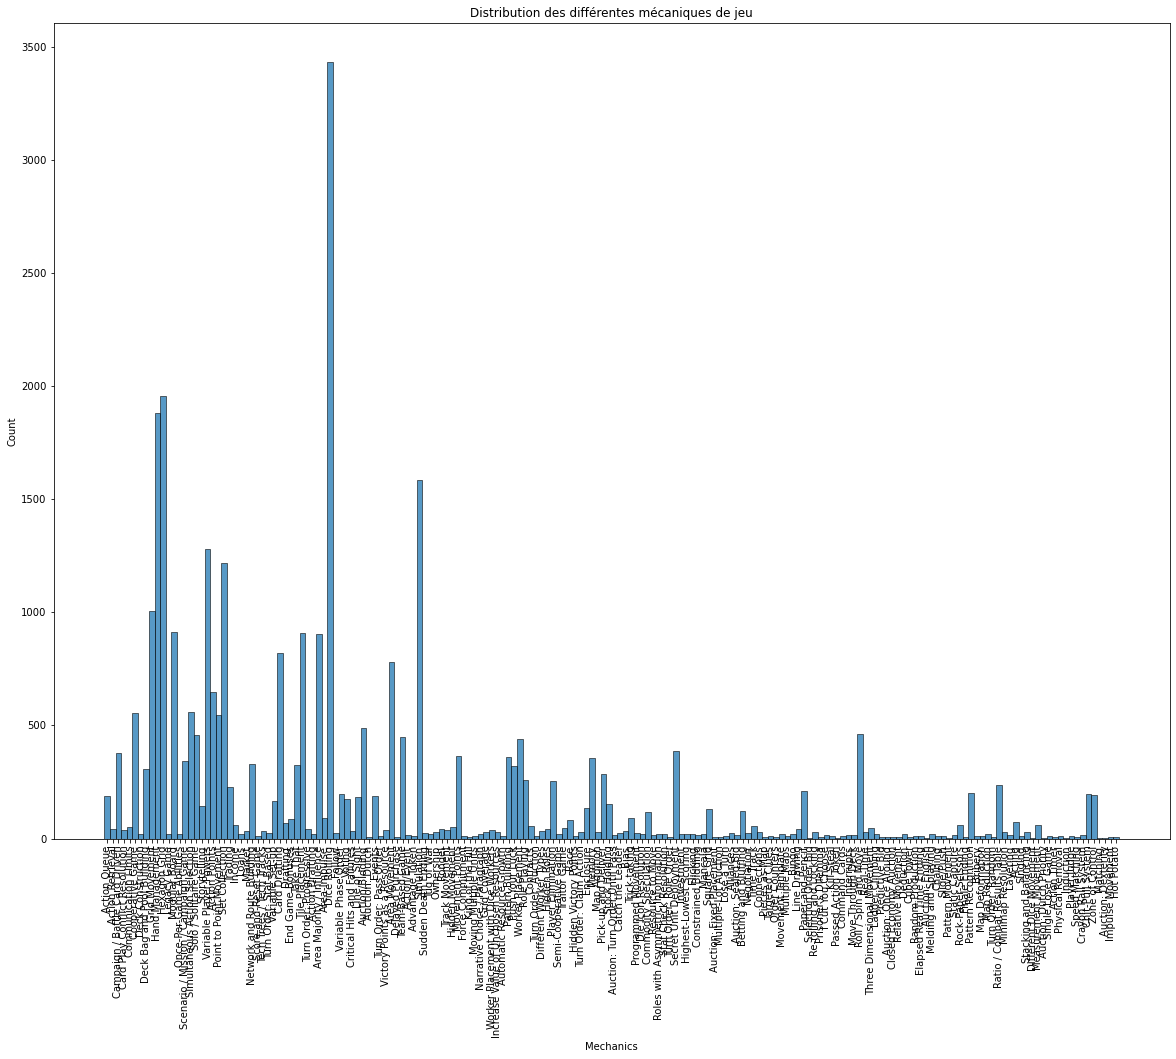

In [75]:
# Set the width and height of the figure
plt.figure(figsize=(20,15))

# Add title
plt.title("Distribution des différentes mécaniques de jeu")

ax=sns.histplot(x=values_df.Mechanics,data=values_df)
plt.xticks(rotation=90)
plt.show()

On créer des variables binaires pour les mécaniques les plus communes pour savoir si le jeu appartient ou non à une mécanique. Il ne paraît pas pertinent de construire une variable par mécanique, cela représenterait trop de variables et certaines mécaniques ne sont pas suffisamment représentées.

On cherche si l'on peut procéder à certains regroupement des mécaniques. <p>
Par exemple, les jeux d'enchères sont séparés dans différentes catégories donc nous regardons combien de jeux sont dans ces catégories afin de voir s'il peut être pertinent de les regrouper pour en faire une catégorie unique.

In [76]:
#Plusieurs jeux utilisent des cartes, on vérifie combien de jeux sont concernés
jeu_map=[]
for i in range(Games.shape[0]) :
    
    if "Map" in Games.Mechanics.iloc[i] :
        jeu_map.append(Games.Name.iloc[i])
print("Il y a", len(jeu_map),"jeux incluant map dans les mécaniques")
print("Cela représente", round((len(jeu_map)/Games.shape[0])*100,3), "% des jeux de la base de données")


Il y a 74 jeux incluant map dans les mécaniques
Cela représente 0.796 % des jeux de la base de données


Il y a trop peu de jeux utilisant des cartes (map) pour qu'il soit pertinent de créer une variable pour ce type de jeu.

In [77]:
jeu_dice=[]
for i in range(Games.shape[0]) :
    
    if "Dice" in Games.Mechanics.iloc[i] :
        jeu_dice.append(Games.Name.iloc[i])
print("Il y a", len(jeu_dice), "jeux de dés")
print("Cela représente", round((len(jeu_dice)/Games.shape[0])*100,3), "% des jeux de la base de données")

Il y a 3437 jeux de dés
Cela représente 36.949 % des jeux de la base de données


On regroupe ensemble tous les jeux de dés

In [78]:
#On créer une colonne pour les jeux de dés
#Si le jeu fait intervenir une mécanique de lancé de dé : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Dice']=None
for i in range(Games.shape[0]) :
    
    if "Dice" in Games.Mechanics.iloc[i] :
        Games['Dice'].iloc[i]=1
    else : 
        Games['Dice'].iloc[i]=0
        
#Créer une liste avec les mécaniques que l'on conserve
liste_mecanique=[]
liste_mecanique.append("Dice")

C:\Users\jacinthe\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [79]:
jeu_turn_order=[]
for i in range(Games.shape[0]) :
    
    if "Turn Order" in Games.Mechanics.iloc[i] :
        jeu_turn_order.append(Games.Name.iloc[i])

print("Il y a", len(jeu_turn_order), "jeux de Turn order")
print("Cela représente", round((len(jeu_turn_order)/Games.shape[0])*100,3), "% des jeux de la base de données")

Il y a 137 jeux de Turn order
Cela représente 1.473 % des jeux de la base de données


Il y a trop peu de jeux de turn order pour que cela soit pertinent de créer une variable pour cette méchanique

In [80]:
jeu_action=[]
for i in range(Games.shape[0]) :
    
    if "Action" in Games.Mechanics.iloc[i] :
        jeu_action.append(Games.Name.iloc[i])

print("Il y a", len(jeu_action), "jeux d'action")
print("Cela représente", round((len(jeu_action)/Games.shape[0])*100,3), "% des jeux de la base de données")


Il y a 1359 jeux d'action
Cela représente 14.61 % des jeux de la base de données


On créer une variable pour les jeux d'actions

In [81]:
#On créer une colonne pour les jeux d'action
#Si le jeu fait intervenir une mécanique d'action : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Action']=None
for i in range(Games.shape[0]) :
    
    if "Action" in Games.Mechanics.iloc[i] :
        Games['Action'].iloc[i]=1
    else : 
        Games['Action'].iloc[i]=0
        
liste_mecanique.append("Action")

In [82]:
jeu_auction=[]
for i in range(Games.shape[0]) :
    
    if "Auction" in Games.Mechanics.iloc[i] :
        jeu_auction.append(Games.Name.iloc[i])
len(jeu_auction)

print("Il y a", len(jeu_auction), "jeux d'action")
print("Cela représente", round((len(jeu_auction)/Games.shape[0])*100,3), "% des jeux de la base de données")

Il y a 508 jeux d'action
Cela représente 5.461 % des jeux de la base de données


Il y a trop peu de jeux d'enchère pour que cela soit pertinent de créer une variable.

In [83]:
jeu_carte=[]
for i in range(Games.shape[0]) :
    
    if "Card" in Games.Mechanics.iloc[i] :
        jeu_carte.append(Games.Name.iloc[i])
len(jeu_carte)

print("Il y a", len(jeu_carte), "jeux d'action")
print("Cela représente", round((len(jeu_carte)/Games.shape[0])*100,3), "% des jeux de la base de données")

Il y a 1193 jeux d'action
Cela représente 12.825 % des jeux de la base de données


On créer une variable pour les jeux de cartes 

In [84]:
#On créer une colonne pour les jeux d'action
#Si le jeu fait intervenir une mécanique d'action : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Card']=None
for i in range(Games.shape[0]) :
    
    if "Card" in Games.Mechanics.iloc[i] :
        Games['Card'].iloc[i]=1
    else : 
        Games['Card'].iloc[i]=0

liste_mecanique.append("Card")

In [85]:
#On créer une colonne pour les grilles hexagonales
#Si le jeu fait intervenir une mécanique de grille hexagonale : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Grid']=None
for i in range(Games.shape[0]) :
    
    if "Hexagon Grid" in Games.Mechanics.iloc[i] :
        Games['Grid'].iloc[i]=1
    else : 
        Games['Grid'].iloc[i]=0
        
liste_mecanique.append("Grid")

In [86]:
#On créer une colonne pour les jeux de gestion de mains
#Si le jeu fait intervenir une mécanique de gestion des cartes en main : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Management']=None
for i in range(Games.shape[0]) :
    
    if "Hand Management" in Games.Mechanics.iloc[i] :
        Games['Management'].iloc[i]=1
    else : 
        Games['Management'].iloc[i]=0

liste_mecanique.append("Management")

In [87]:
#On créer une colonne pour les jeux de simulation
#Si le jeu fait intervenir une mécanique de simulation : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Simulation']=None
for i in range(Games.shape[0]) :
    
    if "Simulation" in Games.Mechanics.iloc[i] :
        Games['Simulation'].iloc[i]=1
    else : 
        Games['Simulation'].iloc[i]=0
        
liste_mecanique.append("Simulation")

In [88]:
#On créer une colonne pour les jeux de Variable Player Powers
#Si le jeu fait intervenir une mécanique de Variable Player Powers : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['VPP']=None
for i in range(Games.shape[0]) :
    
    if "Variable Player Powers" in Games.Mechanics.iloc[i] :
        Games['VPP'].iloc[i]=1
    else : 
        Games['VPP'].iloc[i]=0
        
liste_mecanique.append("VPP")

In [89]:
#On créer une colonne pour les jeux de Set Collection
#Si le jeu fait intervenir une mécanique de set collection : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Set_collection']=None
for i in range(Games.shape[0]) :
    
    if "Set Collection" in Games.Mechanics.iloc[i] :
        Games['Set_collection'].iloc[i]=1
    else : 
        Games['Set_collection'].iloc[i]=0
    
liste_mecanique.append("Set_collection")

In [90]:
#On créer une colonne pour les jeux de Set Collection
#Si le jeu fait intervenir une mécanique de set collection : la variable prend la valeur 1
#Sinon la variable prend la valeur 0
Games['Grid_Movement']=None
for i in range(Games.shape[0]) :
    
    if "Grid Movement" in Games.Mechanics.iloc[i] :
        Games['Grid_Movement'].iloc[i]=1
    else : 
        Games['Grid_Movement'].iloc[i]=0
        
liste_mecanique.append("Grid_Movement")

In [91]:
Games

,Name,Min_players,Max_players,Play_Time,Min_age,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Mechanics,...,Nb_Mechanics,Dice,Action,Card,Grid,Management,Simulation,VPP,Set_collection,Grid_Movement
0,Gloomhaven,1,4,120,14,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...",...,19,0,1,1,1,1,0,1,0,1
1,Pandemic Legacy: Season 1,2,4,60,13,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...",...,8,0,1,0,0,1,0,1,1,0
2,Brass: Birmingham,2,4,120,14,8.66,3,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",...,9,0,0,0,0,1,0,0,0,0
3,Terraforming Mars,1,5,120,12,8.43,4,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",...,12,0,0,1,1,1,0,1,1,0
4,Twilight Imperium: Fourth Edition,3,6,480,14,8.70,5,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...",...,12,1,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20334,LCR,3,12,20,5,3.42,20336,1.05,3441,Dice Rolling,...,1,1,0,0,0,0,0,0,0,0
20335,Monopoly,2,8,180,8,4.39,20337,1.65,40255,"Auction/Bidding, Income, Loans, Lose a Turn, P...",...,10,0,0,0,0,0,0,0,1,0
20336,The Game of Life,2,6,60,8,4.30,20338,1.18,16692,"Roll / Spin and Move, Simulation",...,2,0,0,0,0,0,1,0,0,0
20337,Trouble,2,4,45,4,3.79,20339,1.05,4962,Roll / Spin and Move,...,1,0,0,0,0,0,0,0,0,0


In [92]:
#On supprime la colonne Mechanics du dataframe
Games.drop('Mechanics',axis=1,inplace=True)

<Figure size 720x432 with 0 Axes>

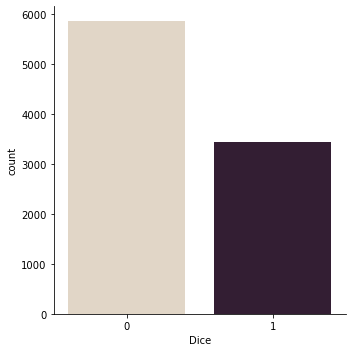

0    5865
1    3437
Name: Dice, dtype: int64


<Figure size 720x432 with 0 Axes>

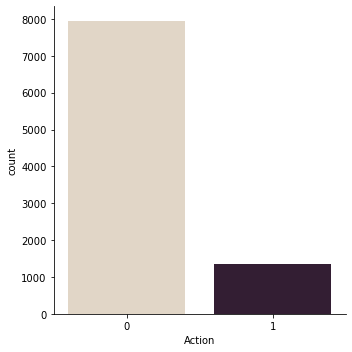

0    7943
1    1359
Name: Action, dtype: int64


<Figure size 720x432 with 0 Axes>

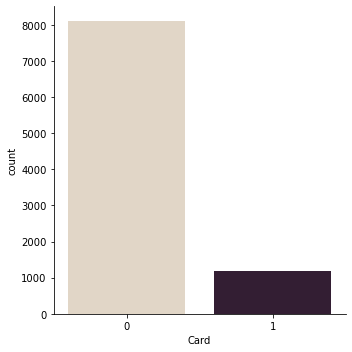

0    8109
1    1193
Name: Card, dtype: int64


<Figure size 720x432 with 0 Axes>

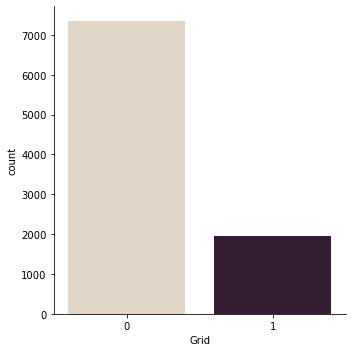

0    7347
1    1955
Name: Grid, dtype: int64


<Figure size 720x432 with 0 Axes>

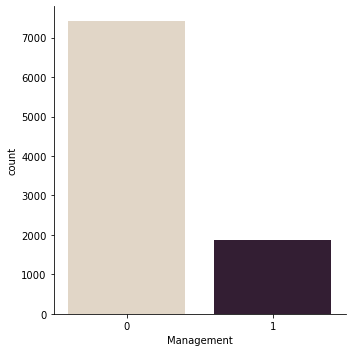

0    7421
1    1881
Name: Management, dtype: int64


<Figure size 720x432 with 0 Axes>

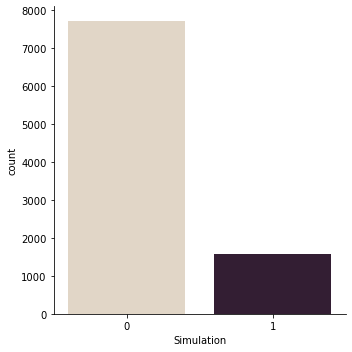

0    7717
1    1585
Name: Simulation, dtype: int64


<Figure size 720x432 with 0 Axes>

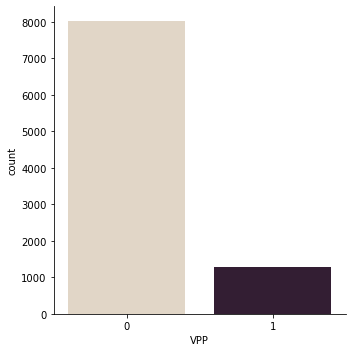

0    8021
1    1281
Name: VPP, dtype: int64


<Figure size 720x432 with 0 Axes>

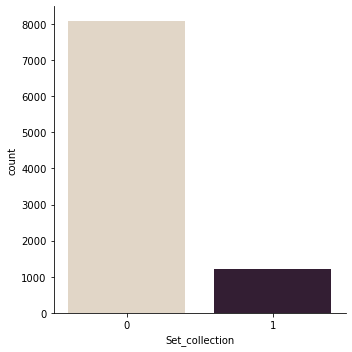

0    8086
1    1216
Name: Set_collection, dtype: int64


<Figure size 720x432 with 0 Axes>

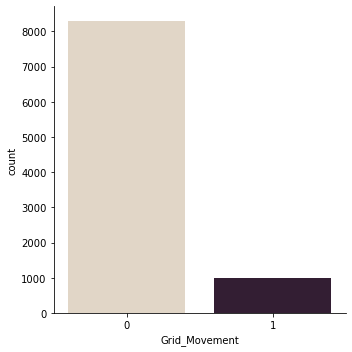

0    8298
1    1004
Name: Grid_Movement, dtype: int64


In [136]:
for i in liste_mecanique :

    plt.figure(figsize=(10,6));


    ax = sns.catplot(data=Games, x=i, kind="count", palette="ch:.25")
    plt.tight_layout()
    plt.show()

    print(Games[i].value_counts())

La variable Domains indique les genres des jeux de société

In [97]:
#On fait une liste avec l'ensemble des domaines qui apparaissent dans le dataset
domaines=[]
for i in Games.Domains :
    value=i.split(",")
    domaines= domaines + value

    #On créer une liste qui contient toutes les domaines de jeu, on retire les espaces inutiles
values=[]
for i in domaines:
    m = i.lstrip()
    values.append(m)
    

In [98]:
unique_dom=np.unique(values).tolist()
print(unique_dom)
print("Il y a ",len(unique_dom), "domaines différents parmi les jeux de la base de données")

['Abstract Games', "Children's Games", 'Customizable Games', 'Family Games', 'Party Games', 'Strategy Games', 'Thematic Games', 'Wargames']
Il y a  8 domaines différents parmi les jeux de la base de données


In [99]:
Games['Nb_domaines']=0
for i in range(Games.shape[0]) :
    value=Games.Domains.iloc[i].split(",")
    Games['Nb_domaines'].iloc[i]=len(value)
    

C:\Users\jacinthe\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [100]:
#Nombre d'occurences de chaque genre
print ([ [l, values.count(l)] for l in set(values)])

[['Strategy Games', 2179], ['Wargames', 3027], ['Abstract Games', 857], ["Children's Games", 689], ['Party Games', 535], ['Thematic Games', 1140], ['Family Games', 2052], ['Customizable Games', 246]]


Il y a une majorité de jeux de guerre dans la base de données, suivie des jeux de stratégie et des jeux familiaux

In [101]:
Games["Thematic"]=None
for i in range(Games.shape[0]) :
    
    if "Thematic Games" in Games.Domains.iloc[i] :
        Games["Thematic"].iloc[i]=1
    else : 
        Games["Thematic"].iloc[i]=0

In [102]:
Games["Abstract"]=None
for i in range(Games.shape[0]) :
    
    if "Abstract Games" in Games.Domains.iloc[i] :
        Games["Abstract"].iloc[i]=1
    else : 
        Games["Abstract"].iloc[i]=0

In [103]:
Games["Party"]=None
for i in range(Games.shape[0]) :
    
    if "Party Games" in Games.Domains.iloc[i] :
        Games["Party"].iloc[i]=1
    else : 
        Games["Party"].iloc[i]=0

In [104]:
Games["Wargames"]=None
for i in range(Games.shape[0]) :
    
    if "Wargames" in Games.Domains.iloc[i] :
        Games["Wargames"].iloc[i]=1
    else : 
        Games["Wargames"].iloc[i]=0

In [105]:
Games["Family"]=None
for i in range(Games.shape[0]) :
    
    if "Family Games" in Games.Domains.iloc[i] :
        Games["Family"].iloc[i]=1
    else : 
        Games["Family"].iloc[i]=0

In [106]:
Games["Customizable"]=None
for i in range(Games.shape[0]) :
    
    if "Customizable Games" in Games.Domains.iloc[i] :
        Games["Customizable"].iloc[i]=1
    else : 
        Games["Customizable"].iloc[i]=0

In [107]:
Games["Strategy"]=None
for i in range(Games.shape[0]) :
    
    if "Strategy Games" in Games.Domains.iloc[i] :
        Games["Strategy"].iloc[i]=1
    else : 
        Games["Strategy"].iloc[i]=0

In [108]:
Games["Children"]=None
for i in range(Games.shape[0]) :
    
    if "Children's Games" in Games.Domains.iloc[i] :
        Games["Children"].iloc[i]=1
    else : 
        Games["Children"].iloc[i]=0

In [109]:
Games.head()

,Name,Min_players,Max_players,Play_Time,Min_age,Rating_avg,BGG_rank,Complexity_avg,Owned_users,Domains,...,Grid_Movement,Nb_domaines,Thematic,Abstract,Party,Wargames,Family,Customizable,Strategy,Children
0,Gloomhaven,1,4,120,14,8.79,1,3.86,68323,"Strategy Games, Thematic Games",...,1,2,1,0,0,0,0,0,1,0
1,Pandemic Legacy: Season 1,2,4,60,13,8.61,2,2.84,65294,"Strategy Games, Thematic Games",...,0,2,1,0,0,0,0,0,1,0
2,Brass: Birmingham,2,4,120,14,8.66,3,3.91,28785,Strategy Games,...,0,1,0,0,0,0,0,0,1,0
3,Terraforming Mars,1,5,120,12,8.43,4,3.24,87099,Strategy Games,...,0,1,0,0,0,0,0,0,1,0
4,Twilight Imperium: Fourth Edition,3,6,480,14,8.70,5,4.22,16831,"Strategy Games, Thematic Games",...,1,2,1,0,0,0,0,0,1,0


In [110]:
#On supprime la colonne Domains du dataframe
Games.drop('Domains',axis=1,inplace=True)

<b> Statistiques descriptives

Représentation de la répartition du nombre de jeux par genre de jeu

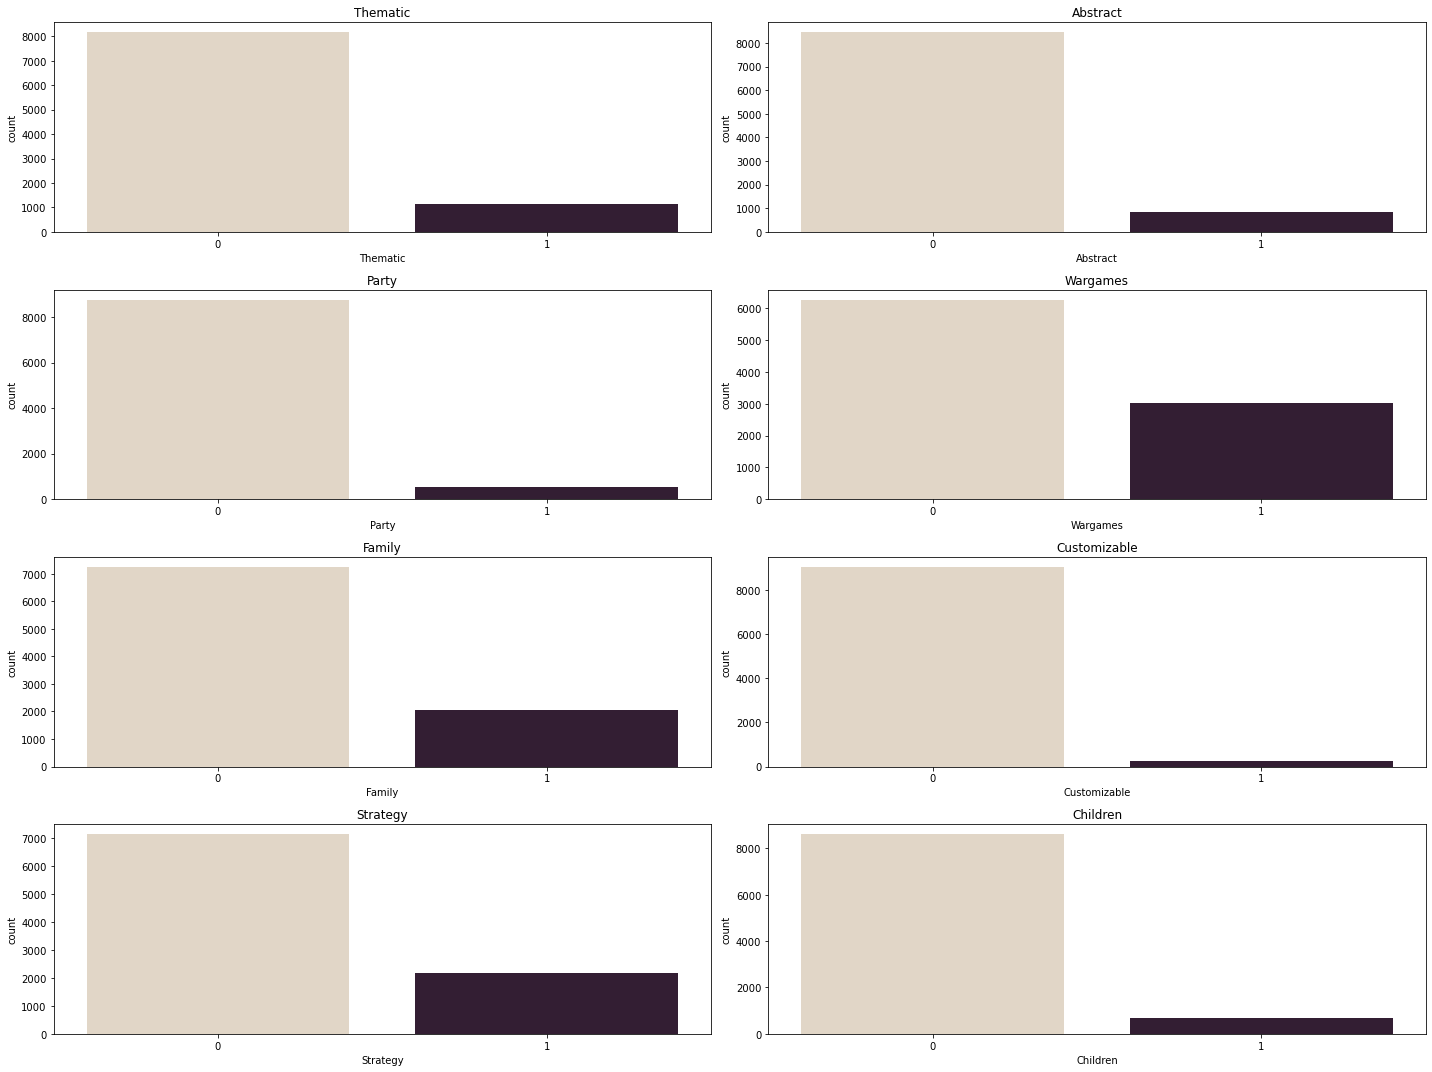

In [111]:
fig=plt.figure(figsize=(20,15),facecolor='white')

gs=fig.add_gridspec(4,2)

ax=[_ for _ in range(9)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])

ax[2]=fig.add_subplot(gs[1,0])
ax[3]=fig.add_subplot(gs[1,1])

ax[4]=fig.add_subplot(gs[2,0])
ax[5]=fig.add_subplot(gs[2,1])

ax[6]=fig.add_subplot(gs[3,0])
ax[7]=fig.add_subplot(gs[3,1])


sns.countplot(data=Games, x="Thematic",  palette="ch:.25",ax=ax[0]).set_title("Thematic")
sns.countplot(data=Games, x="Abstract",  palette="ch:.25",ax=ax[1]).set_title("Abstract")
sns.countplot(data=Games, x="Party",  palette="ch:.25",ax=ax[2]).set_title("Party")
sns.countplot(data=Games, x="Wargames",  palette="ch:.25",ax=ax[3]).set_title("Wargames")
sns.countplot(data=Games, x="Family",  palette="ch:.25",ax=ax[4]).set_title("Family")
sns.countplot(data=Games, x="Customizable",  palette="ch:.25",ax=ax[5]).set_title("Customizable")
sns.countplot(data=Games, x="Strategy",  palette="ch:.25",ax=ax[6]).set_title("Strategy")
sns.countplot(data=Games, x="Children",  palette="ch:.25",ax=ax[7]).set_title("Children")


plt.tight_layout()
plt.show()

In [112]:
liste_domaines=["Thematic","Abstract","Party","Wargames","Family","Customizable","Strategy","Children"]

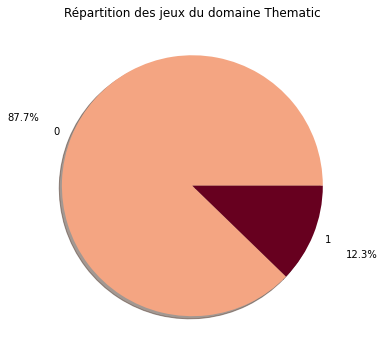

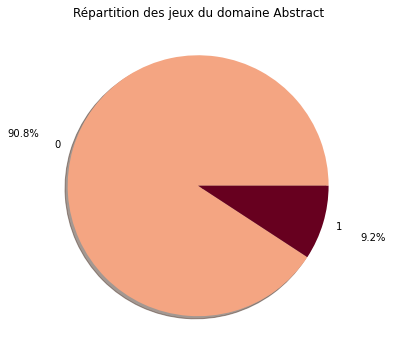

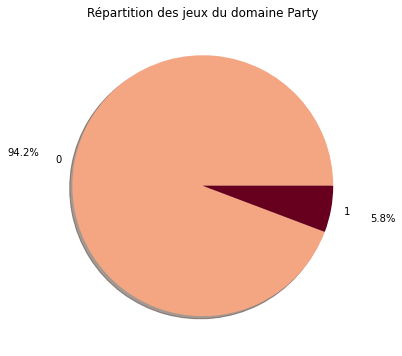

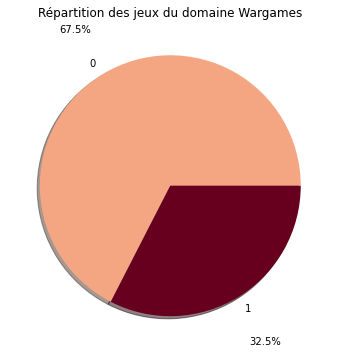

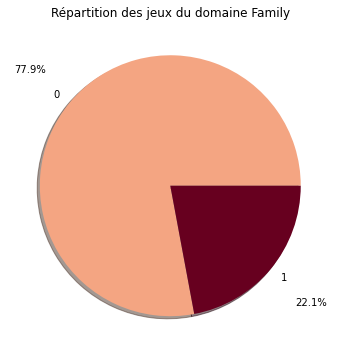

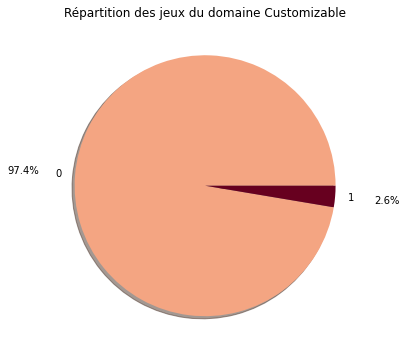

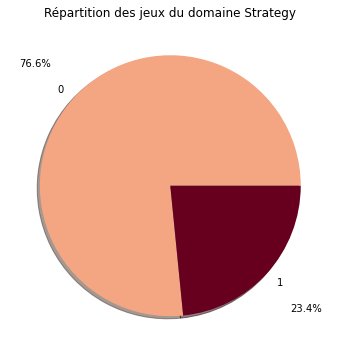

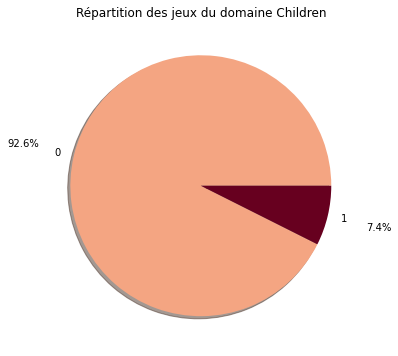

In [147]:
for i in liste_domaines :
    fig=plt.figure(figsize=(10,6),facecolor='white')
    plt.pie(Games[i].value_counts().values, labels=Games[i].value_counts().index,colors=['#F4A582','#67001F'],pctdistance=1.4, autopct='%1.1f%%', shadow=True)
    plt.title("Répartition des jeux du domaine "+i)
    plt.show()

<h1> Note Moyenne

In [114]:
Games.Rating_avg.describe()

count    9302.000000
mean        6.626050
std         0.835887
min         2.830000
25%         6.110000
50%         6.650000
75%         7.200000
max         9.340000
Name: Rating_avg, dtype: float64

In [115]:
#On fait une liste des colonnes numériques pour calculer ensuite les corrélations
columns=Games.columns.tolist()
col_to_drop=["Name","Dice","Action","Card","Grid","Management",'Simulation','VPP', 'Set_collection', 'Grid_Movement','Thematic', 'Abstract', 'Party', 'Wargames', 'Family', 'Customizable', 'Strategy', 'Children',"Rating_avg"]
for i in col_to_drop :
    columns.remove(i)
    
columns.append("Rating_avg")

In [116]:
Games[columns]

,Min_players,Max_players,Play_Time,Min_age,BGG_rank,Complexity_avg,Owned_users,Age,Nb_Mechanics,Nb_domaines,Rating_avg
0,1,4,120,14,1,3.86,68323,4,19,2,8.79
1,2,4,60,13,2,2.84,65294,6,8,2,8.61
2,2,4,120,14,3,3.91,28785,3,9,1,8.66
3,1,5,120,12,4,3.24,87099,5,12,1,8.43
4,3,6,480,14,5,4.22,16831,4,12,2,8.70
...,...,...,...,...,...,...,...,...,...,...,...
20334,3,12,20,5,20336,1.05,3441,38,1,2,3.42
20335,2,8,180,8,20337,1.65,40255,88,10,1,4.39
20336,2,6,60,8,20338,1.18,16692,61,2,1,4.30
20337,2,4,45,4,20339,1.05,4962,56,1,1,3.79


Complexity_avg    0.522948
Min_age           0.430795
Nb_Mechanics      0.348826
Play_Time         0.292152
Owned_users       0.206146
Nb_domaines      -0.011696
Max_players      -0.038319
Min_players      -0.162893
Age              -0.379175
BGG_rank         -0.718868
Name: Corr, dtype: float64


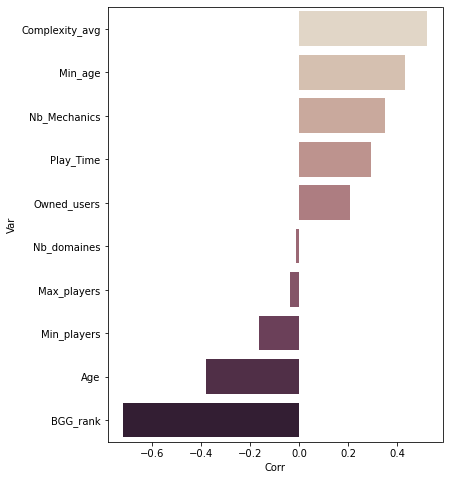

In [117]:
#Représentation des corrélations avec la variable rating average :

df_num=Games[columns].copy()

df_num_corr = df_num.corr()['Rating_avg'][:-1] # -1 because the latest row is SalePrice
Features_list = df_num_corr.sort_values(ascending=False)

df_corr=pd.DataFrame({'Var':df_num_corr.index,'Corr':df_num_corr})
corr_order=df_corr.sort_values("Corr", ascending=False)

f, ax = plt.subplots(figsize=(6, 8))

sns.barplot(x=corr_order['Corr'],y=corr_order['Var'], data=corr_order,palette="ch:.25")
print(corr_order['Corr'])

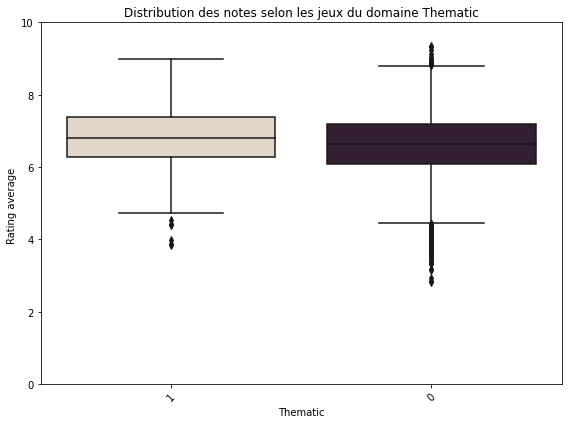

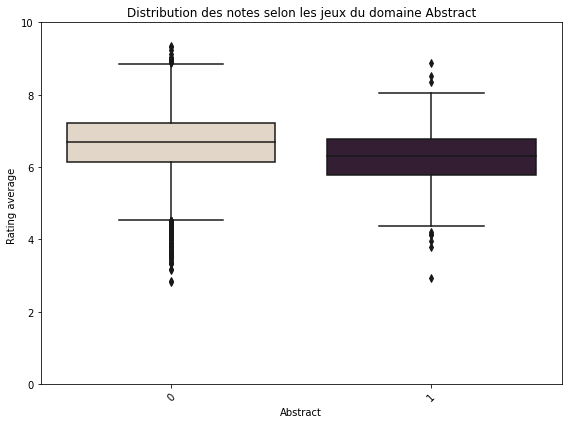

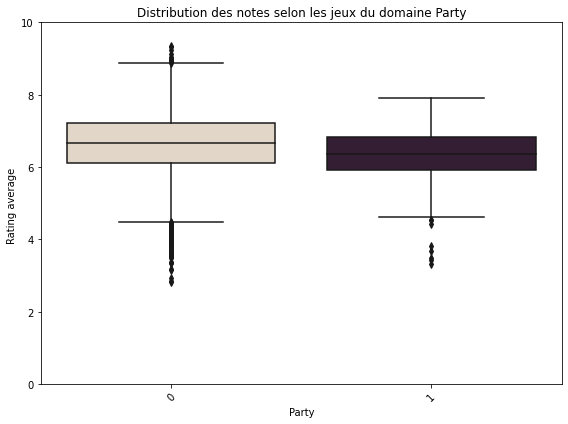

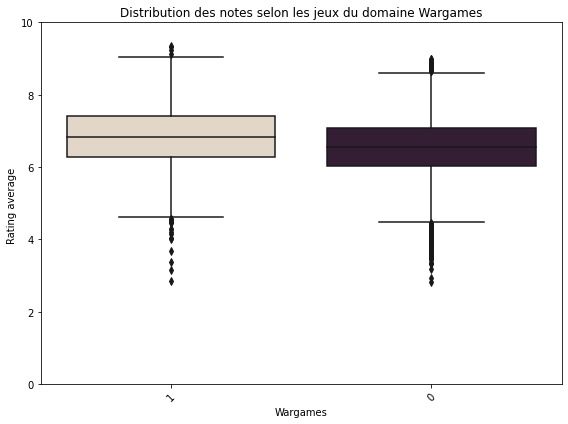

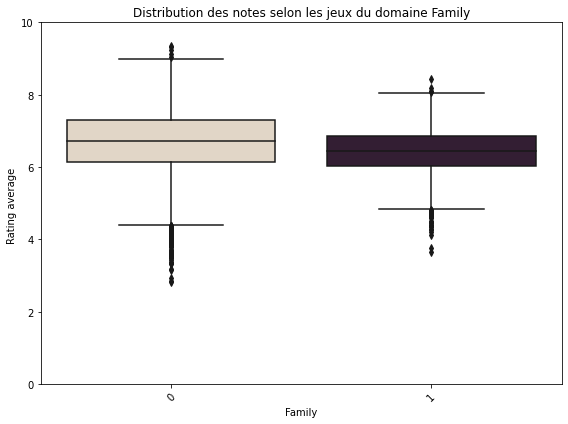

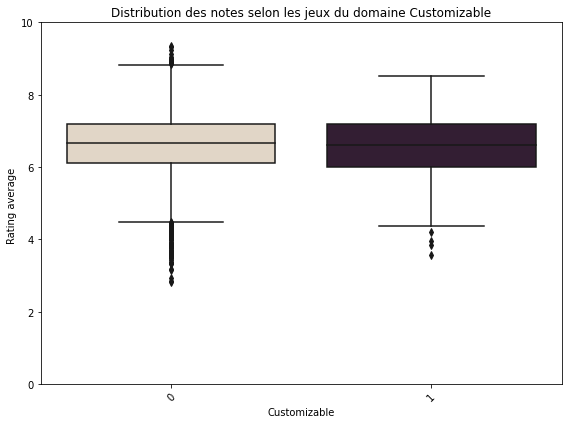

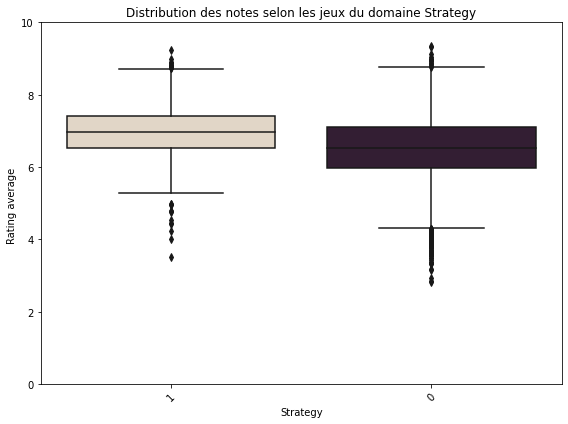

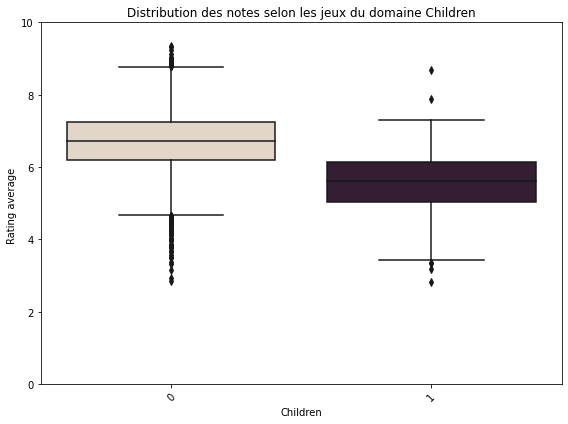

In [118]:
for i in liste_domaines :
    order = Games.groupby(i).Rating_avg.mean().sort_values(ascending=False).index

    plt.figure(figsize=(8,6));

    ax = sns.boxplot(x=i, y="Rating_avg", data=Games, order=order,palette="ch:.25")
    plt.axis(ymin=0, ymax=10)
    plt.title("Distribution des notes selon les jeux du domaine "+i)
    plt.ylabel("Rating average ")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


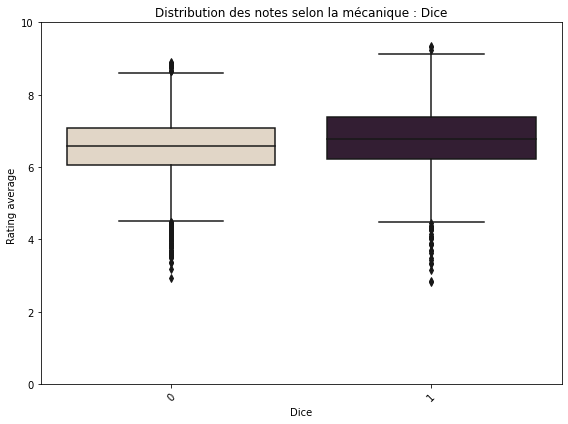

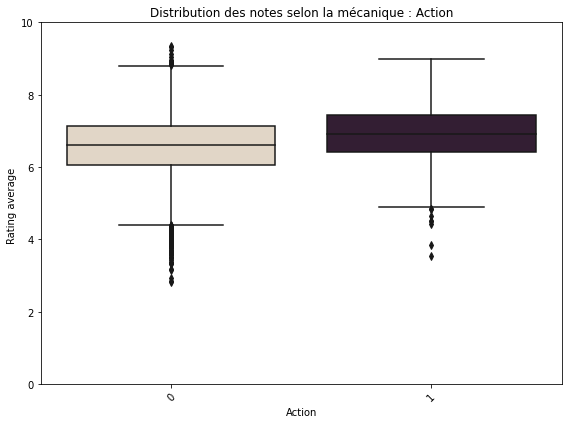

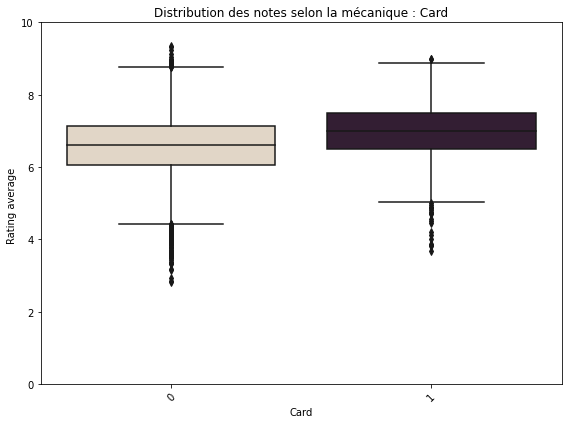

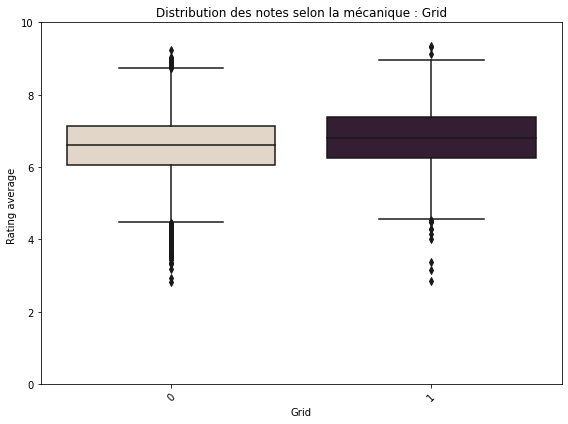

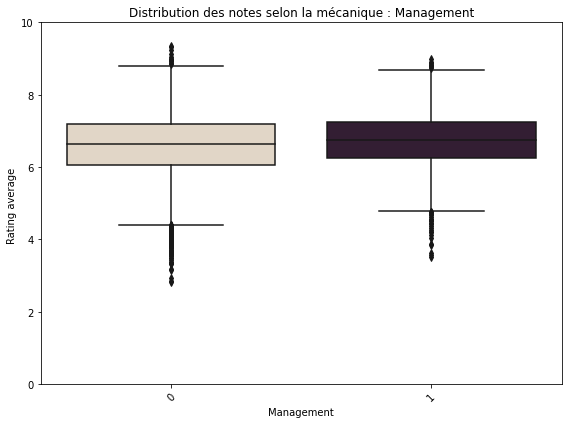

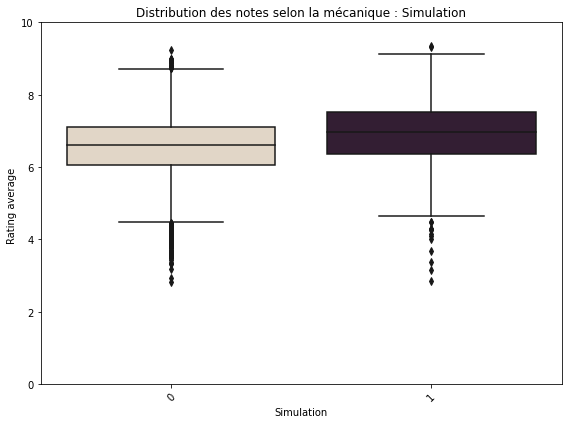

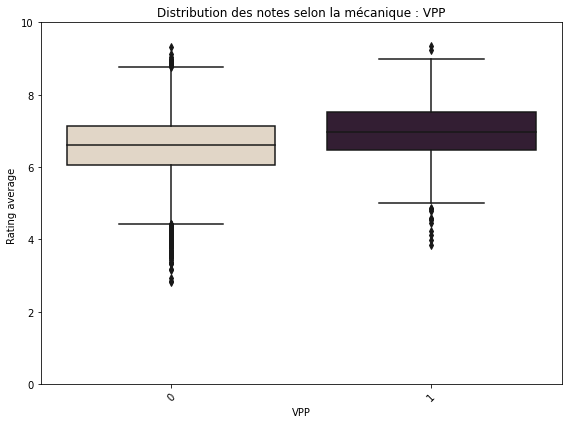

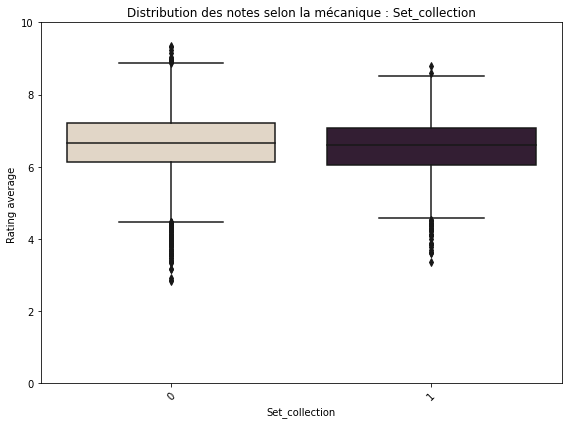

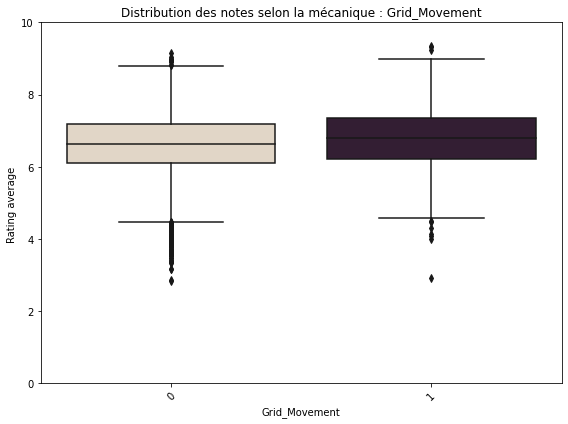

In [119]:
for i in liste_mecanique :

    plt.figure(figsize=(8,6));

    ax = sns.boxplot(x=i, y="Rating_avg", data=Games, palette="ch:.25")
    plt.axis(ymin=0, ymax=10)
    plt.title("Distribution des notes selon la mécanique : "+i)
    plt.ylabel("Rating average ")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<h1> Modélisation

In [120]:
#On créer une copie du dataset dans lequel la varaible Rating_avg soit placée en fin de dataset pour faciliter la manipulation
columns=Games.columns.tolist()
columns.remove("Rating_avg")
columns.append("Rating_avg")
Games2=Games[columns].copy()

In [121]:
#Train and test
X_train , X_test, y_train, y_test = train_test_split(Games2.iloc[:,1:27],
                                                     Games2.Rating_avg,
                                                     test_size=0.2)

In [122]:
#Standardiser les features
scaler = StandardScaler()
scaler.fit(X_train)
# On transforme X_train et X_test avec le calcul de moyenne et std du X_train
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [149]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
#Initialisation du modèle
reg_model = keras.models.Sequential()
#Shape input, number of columns
reg_model.add(keras.layers.Input(shape=X_train_sc.shape[1]))#input layer
reg_model.add(keras.layers.Dense(28, activation='relu'))#Hidden layer, 100 neurones
reg_model.add(keras.layers.Dense(1))#Output layer

#Compil model parameter
reg_model.compile(loss=keras.losses.mean_squared_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01)
                 )
#Fit model

In [125]:
history = reg_model.fit(X_train_sc, y_train,batch_size=24 ,epochs=50, validation_split=0.2)

Epoch 1/50
248/248 [==============================] - 2s 4ms/step - loss: 2.1101 - val_loss: 0.3760
Epoch 2/50
248/248 [==============================] - 1s 2ms/step - loss: 0.3151 - val_loss: 0.2527
Epoch 3/50
248/248 [==============================] - 1s 3ms/step - loss: 0.2470 - val_loss: 0.2485
Epoch 4/50
248/248 [==============================] - 1s 3ms/step - loss: 0.2249 - val_loss: 0.2083
Epoch 5/50
248/248 [==============================] - 1s 3ms/step - loss: 0.2050 - val_loss: 0.2153
Epoch 6/50
248/248 [==============================] - 1s 4ms/step - loss: 0.1970 - val_loss: 0.2111
Epoch 7/50
248/248 [==============================] - 1s 3ms/step - loss: 0.1866 - val_loss: 0.1878
Epoch 8/50
248/248 [==============================] - 1s 3ms/step - loss: 0.1756 - val_loss: 0.2008
Epoch 9/50
248/248 [==============================] - 1s 3ms/step - loss: 0.1743 - val_loss: 0.1838
Epoch 10/50
248/248 [==============================] - 1s 3ms/step - loss: 0.1690 - val_loss: 0.1924

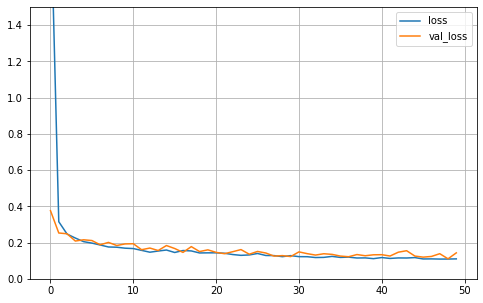

In [126]:
import matplotlib.pyplot as plt

#Data to pandas dataframe
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) 
plt.show()

In [150]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [151]:
#Initialisation du modèle
reg_model = keras.models.Sequential()
#Shape input, number of columns
reg_model.add(keras.layers.Input(shape=X_train_sc.shape[1]))#input layer
reg_model.add(keras.layers.Dense(28, activation='relu'))#Hidden layer, 100 neurones
reg_model.add(keras.layers.Dense(18, activation='relu'))
reg_model.add(keras.layers.Dense(1))#Output layer

#Compil model parameter
reg_model.compile(loss=keras.losses.mean_squared_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01)
                 )
#Fit model

In [152]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          2700        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 200)          20200       ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 226)          0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [153]:
history = reg_model.fit(X_train_sc, y_train,batch_size=128 ,epochs=100, validation_split=0.2)

Epoch 1/100
47/47 [==============================] - 2s 8ms/step - loss: 5.1896 - val_loss: 0.7338
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.4911 - val_loss: 0.4169
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 0.3382 - val_loss: 0.3264
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2766 - val_loss: 0.2675
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2377 - val_loss: 0.2421
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2167 - val_loss: 0.2219
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.2038 - val_loss: 0.2340
Epoch 8/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1971 - val_loss: 0.1985
Epoch 9/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1860 - val_loss: 0.2026
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 0.1815 - val_loss: 0.1912
Epoch 11/

47/47 [==============================] - 0s 4ms/step - loss: 0.0870 - val_loss: 0.1177
Epoch 84/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0856 - val_loss: 0.1130
Epoch 85/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0847 - val_loss: 0.1073
Epoch 86/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0889 - val_loss: 0.1033
Epoch 87/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0845 - val_loss: 0.1064
Epoch 88/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0832 - val_loss: 0.1154
Epoch 89/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0872 - val_loss: 0.1157
Epoch 90/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0841 - val_loss: 0.1190
Epoch 91/100
47/47 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.1115
Epoch 92/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0850 - val_loss: 0.1104
Epoch 93/100


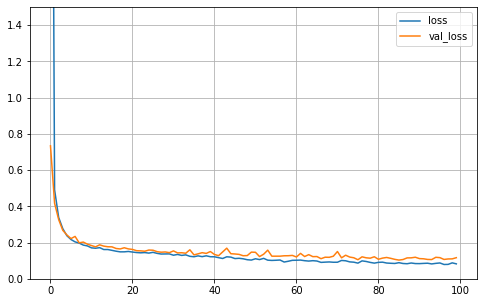

In [156]:
#Data to pandas dataframe
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) 
plt.show()

In [155]:
#Validation out sample
mse_test = model.evaluate(X_test, y_test)
# ATTENTION A BIEN FAIRE X[:k] et pas X[k]
X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_new)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

<b> Wide and deep

In [127]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [128]:
#set seed
#Define first layer
input_ = keras.layers.Input(shape=X_train_sc.shape[1:])
#Hidden layer
hidden1 = keras.layers.Dense(100, activation="relu")(input_)
hidden2 = keras.layers.Dense(200, activation="relu")(hidden1)
#Concat first layer and output hidden
concat = keras.layers.Concatenate()([input_, hidden2])
#Output layer
output = keras.layers.Dense(1)(concat)
#define model
model = keras.Model(inputs=[input_], outputs=[output])

In [129]:
#Compil model parameter
model.compile(loss="mean_squared_error", 
                  optimizer=tf.optimizers.Adam(learning_rate=0.01))
#Fit model

In [130]:
wide_deep_history = model.fit(X_train_sc, y_train,batch_size=32 ,epochs=50, validation_split=0.2)

Epoch 1/50
186/186 [==============================] - 2s 4ms/step - loss: 1.2219 - val_loss: 0.3430
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.2680 - val_loss: 0.2895
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.2751 - val_loss: 0.3215
Epoch 4/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2599 - val_loss: 0.2412
Epoch 5/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2489 - val_loss: 0.2382
Epoch 6/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2219 - val_loss: 0.2146
Epoch 7/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2235 - val_loss: 0.2656
Epoch 8/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2092 - val_loss: 0.2765
Epoch 9/50
186/186 [==============================] - 1s 3ms/step - loss: 0.2087 - val_loss: 0.2104
Epoch 10/50
186/186 [==============================] - 1s 3ms/step - loss: 0.1850 - val_loss: 0.2095

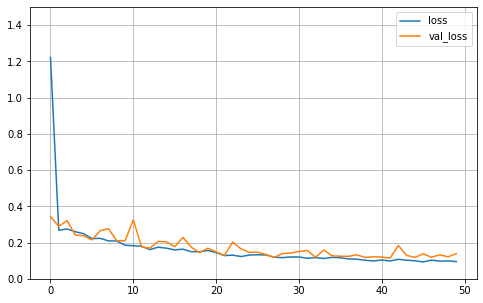

In [154]:
#Data to pandas dataframe
pd.DataFrame(wide_deep_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) 
plt.show()

<b> Cross Validation

In [132]:
def build_model(n_hidden, n_neurons, lr,input_shape):
    #Define sequential model
    model = keras.models.Sequential()
    #Input shape
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    #Add hidden layer with loop
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    #Ouput layer    
    model.add(keras.layers.Dense(1))
    #Define optimizer
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    #Compile model
    model.compile(loss="mse", optimizer=optimizer)
    return(model)


In [133]:
#Keras wrapper
keras_reg = KerasRegressor(build_model)

NameError: name 'KerasRegressor' is not defined

In [ ]:
param_distribs = {
"model__n_hidden": [1, 2, 3],
"model__n_neurons":[50,100,200],
"model__lr":  [0.0001, 0.001, 0.1],
"model__input_shape":[X_train_sc.shape[1]],
"epochs":[30],
"batch_size":[24]
}

In [ ]:
rnd_search_cv = GridSearchCV(keras_reg, param_distribs,cv=3, scoring='neg_mean_squared_error')
#Fit model with grid search
rnd_search_cv.fit(X_train_sc, y_train)

print(rnd_search_cv.best_params_, rnd_search_cv.best_score_)

In [ ]:
opti_model = build_model(n_hidden =3 , n_neurons=200, lr =0.001 ,input_shape= X_train_sc.shape[1])

In [ ]:
opti_histori = opti_model.fit(X_train_sc, y_train,batch_size=24 ,epochs=50, validation_split=0.2)

In [ ]:
pd.DataFrame(opti_histori.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10) 
plt.show()